We shall now build and train a Convolutional Neural Network on the augmented Oxford IIIT Pet Dataset.

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

We shall use the Dataset class to build a custom dataset class inheriting from it.

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

Let's define the transforms, read_image already reads the images as tensors so we don't need to use ToTensor, we shall only resize the images to (size,size) pixels. We shall use the NLL Loss later, this expects as target a class index ranging from 0 to C-1. So we don't need one-hot encoding for the target, but in principle we could do it as shown below. 

In [3]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])     # totensor has to be applied first and then resize coz the latter doesn't work on numpy arrays
#label_transform_one_hot = T.Lambda(lambda y: torch.zeros(37, dtype=torch.float).scatter_(dim=0,index=torch.tensor(y),value=1))

In [4]:
train_r1 = PetDataset('annotations_aug/annotations_train_r1.csv','img_augmented_processed/', transform = trans)
train_r2 = PetDataset('annotations_aug/annotations_train_r2.csv','img_augmented_processed/', transform = trans)
train_r3 = PetDataset('annotations_aug/annotations_train_r3.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [5]:
train_r1_loader = DataLoader(train_r1,batch_size=64,shuffle=True)
train_r2_loader = DataLoader(train_r2,batch_size=64,shuffle=True)
train_r3_loader = DataLoader(train_r3,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

We can call the first batch in the following way:

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


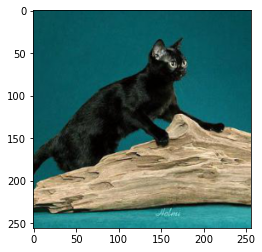

In [6]:
train_b1_img, train_b1_label = next(iter(train_r1_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model

In [25]:
class PetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    #nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    #nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential(
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential(
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.Dropout2d(0.3),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential(
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),
                                    nn.Dropout(0.4),
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        #self.conv7 = nn.Sequential(
        #                            nn.Conv2d(in_channels=256, out_channels=300, kernel_size=3),
        #                            nn.Dropout(0.5),
        #                            nn.BatchNorm2d(300),
        #                            nn.ReLU())
        
        #self.conv8 = nn.Sequential(
        #                            nn.Conv2d(in_channels=300, out_channels=370, kernel_size=3),
        #                            nn.BatchNorm2d(370),
        #                            nn.Dropout(0.5),
        #                            nn.ReLU())
        
        self.dense1 = nn.Sequential(
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        #out = self.conv7(out)
        #out = self.conv8(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN()
loss_function = nn.NLLLoss()


print(model)
        

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, pad

# Training on a small batch

We shall now try to train the model above on a small batch obtained from each of the three training data sets that we have. If we are able to overtrain (achieve almost total training accuracy) on these small datasets, we'll go ahead and check if we can achieve very high training accuracy on the entire training sets.

In [27]:
# Trying to overtrain on a small batch from set r1

model1 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate)


train_r1_loader_temp = DataLoader(train_r1,batch_size=256,shuffle=True)
x = next(iter(train_r1_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(200):
    model1.train()       # to set the model in training mode coz batchnorm will behave differently in the eval mode
    
    out = model1(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model1.eval()
        with torch.no_grad():
            out = model1(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/256))
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))        # time taken for the last 20 iterations
    
            
        start = time.time()      
       
        

    


Iteration:20
Loss:3.611985683441162
Accuracy:0.03125
Time taken for the last 20 iterations: 57.301703691482544
Iteration:40
Loss:3.6104378700256348
Accuracy:0.0390625
Time taken for the last 20 iterations: 62.5105037689209
Iteration:60
Loss:3.4679336547851562
Accuracy:0.14453125
Time taken for the last 20 iterations: 62.36521553993225
Iteration:80
Loss:3.1575233936309814
Accuracy:0.421875
Time taken for the last 20 iterations: 61.93339657783508
Iteration:100
Loss:2.9201834201812744
Accuracy:0.57421875
Time taken for the last 20 iterations: 61.6844584941864
Iteration:120
Loss:2.7572784423828125
Accuracy:0.67578125
Time taken for the last 20 iterations: 63.0110878944397
Iteration:140
Loss:2.55171799659729
Accuracy:0.76953125
Time taken for the last 20 iterations: 62.28511714935303
Iteration:160
Loss:2.3424668312072754
Accuracy:0.828125
Time taken for the last 20 iterations: 61.8873929977417
Iteration:180
Loss:2.1209444999694824
Accuracy:0.87109375
Time taken for the last 20 iterations: 6

In [10]:
# Trying to overtrain on a small batch from set r2

model2 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model2.parameters(),lr=learning_rate)

train_r2_loader_temp = DataLoader(train_r2,batch_size=512,shuffle=True)
x = next(iter(train_r2_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(140):
    model2.train()
    
    out = model2(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model2.eval()
        with torch.no_grad():
            out = model2(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/512))
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))      
                    
        start = time.time()      
       
        

    


KeyboardInterrupt: 

In [13]:
# Trying to overtrain on a small batch from set r3

model3 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model3.parameters(),lr=learning_rate)

train_r3_loader_temp = DataLoader(train_r3,batch_size=512,shuffle=True)
x = next(iter(train_r3_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(140):
    model3.train()
    
    out = model3(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model3.eval()
        with torch.no_grad():
            out = model3(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/512))
            
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))      
    
            
        start = time.time()      
       
        

    


Iteration:20
Loss:3.6263747215270996
Accuracy:0.03125
Time taken for the last 20 iterations: 85.89708304405212
Iteration:40
Loss:3.564344882965088
Accuracy:0.05078125
Time taken for the last 20 iterations: 102.10571122169495
Iteration:60
Loss:0.5015668272972107
Accuracy:1.0
Time taken for the last 20 iterations: 105.49361896514893
Iteration:80
Loss:0.08511313796043396
Accuracy:1.0
Time taken for the last 20 iterations: 104.16592526435852
Iteration:100
Loss:0.0561002753674984
Accuracy:1.0
Time taken for the last 20 iterations: 107.718665599823
Iteration:120
Loss:0.04422798380255699
Accuracy:1.0
Time taken for the last 20 iterations: 104.83716177940369
Iteration:140
Loss:0.036587055772542953
Accuracy:1.0
Time taken for the last 20 iterations: 105.38210868835449


# Training on the entire dataset

We shall now check if we can overtrain our models on the entire datasets.

In [28]:
model1 = PetCNN()
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 50

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                
               
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,12000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,12000)
acc_graph.set_ylim(0,1)

plt.show()
            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 34.66441750526428
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 38.91284489631653
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 38.28457021713257
Current training loss:3.3347091674804688
Current training accuracy:0.09130859375
Current validation loss:3.352257013320923
Current validation accuracy:0.08718980848789215
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 38.52504301071167
Current training loss:3.3657290935516357
Current training accuracy:0.0771484375
Current validation loss:3.3889873027801514
Current validation accuracy:0.07042253762483597
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 39.6397750377655
Current training loss:3.07631778717041
Current training accuracy:0.1494140625
Current validation loss:3.118375539779663
Current validation accuracy:0.13346746563911438
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 41.237332344055176
Current training 

Current training loss:1.6030473709106445
Current training accuracy:0.51123046875
Current validation loss:2.231931209564209
Current validation accuracy:0.36686787009239197
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 38.25251364707947
Current training loss:2.028230905532837
Current training accuracy:0.390625
Current validation loss:2.7028231620788574
Current validation accuracy:0.29845741391181946
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 38.315887212753296
Current training loss:1.7508593797683716
Current training accuracy:0.4736328125
Current validation loss:2.43782377243042
Current validation accuracy:0.3380281627178192
Epoch:16
Iteration:1900
Time taken for the last 50 iterations: 37.74277186393738
Current training loss:1.4344398975372314
Current training accuracy:0.55859375
Current validation loss:2.2280526161193848
Current validation accuracy:0.3816230595111847
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 35.772395849227905
C

Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 35.56467652320862
Current training loss:0.7881407737731934
Current training accuracy:0.759765625
Current validation loss:2.0459821224212646
Current validation accuracy:0.4553990662097931
Epoch:30
Iteration:3450
Time taken for the last 50 iterations: 36.15551233291626
Current training loss:0.7409363389015198
Current training accuracy:0.7890625
Current validation loss:2.067293405532837
Current validation accuracy:0.45741114020347595
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 35.44579815864563
Current training loss:0.8673616051673889
Current training accuracy:0.7392578125
Current validation loss:2.1983771324157715
Current validation accuracy:0.4272300601005554
Epoch:31
Iteration:3550
Time taken for the last 50 iterations: 36.3045175075531
Current training loss:0.654088020324707
Current training accuracy:0.810546875
Current validation loss:2.0496580600738525
Current validation accuracy:0.46747151017189026
Ep

KeyboardInterrupt: 

Comments on training model 1: Initially I started with 8 conv layers and 1 dense layer. I could achieve total accuracy on a small batch of data (so maybe the model is too elaborate?). On the entire dataset, at lr=0.001 (dr=0.1 lr, adding weight decay is equivalent to l2 regularization of the loss fn), the model started overfitting at validation accuracy of around 30%. Next, I'm trying with a lower lr=0.0001, after 25 epochs it seems like the training loss is decreasing much faster than the validation loss, so we need to modify the model. Adding some dropout2d in the initial conv layers (as ordinary dropout is not very effective here), and plain dropout in the later layers. Still not enough, so I guess we'll try simplifying the model.

In [29]:
class PetCNNreg(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    #nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4),
                                    nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4),
                                    nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential(
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3),
                                    nn.Dropout(0.2),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential(
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    #nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.Dropout(0.4),
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        #self.conv6 = nn.Sequential(
        #                            nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
        #                            nn.MaxPool2d(kernel_size=3,stride=1),
        #                            nn.Dropout(0.4),
        #                            nn.BatchNorm2d(370),
        #                            nn.ReLU())
        
        #self.conv7 = nn.Sequential(
        #                            nn.Conv2d(in_channels=256, out_channels=300, kernel_size=3),
        #                            nn.Dropout(0.5),
        #                            nn.BatchNorm2d(300),
        #                            nn.ReLU())
        
        #self.conv8 = nn.Sequential(
        #                            nn.Conv2d(in_channels=300, out_channels=370, kernel_size=3),
        #                            nn.BatchNorm2d(370),
        #                            nn.Dropout(0.5),
        #                            nn.ReLU())
        
        self.dense1 = nn.Sequential(
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        #out = self.conv6(out)
        #out = self.conv7(out)
        #out = self.conv8(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


loss_function = nn.NLLLoss()

model1 = PetCNNreg()
print(model)


learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 50

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                
               
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,12000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,12000)
acc_graph.set_ylim(0,1)

plt.show()
            
        

    

        

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, pad

RuntimeError: Given input size: (128x3x3). Calculated output size: (128x0x0). Output size is too small